In [ ]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


Author: Callum Pittner cap37

---


Date: 28/04/2021

---


Version: 2.0

GATHER STOCK DATA ->

In [ ]:
#Specified Stock tag
ticker = 'AAPL'

In [ ]:
#Declare the start and end times for the training dataset
training_start = dt.datetime(2000,1,1)
training_end = dt.datetime(2020, 1, 1)

data = pdr.DataReader(ticker, 'yahoo', training_start, training_end)

In [ ]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.859423
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.786965
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.798481
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.729382
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.763932
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.234581
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.628067
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.600876


PREPARE DATA

In [ ]:
#MinMaxScaler will scale the prices in the dataset to values between 0-1, this is
#done to communicate time series data effectively to the model.
scaler = MinMaxScaler(feature_range=(0,1))
#focusing on only the close values, reshaped array for formatting purposes.
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
#use a specified number of days to predict future value
lookback_days = 30

In [ ]:
#training datasets
x_train = []
y_train = []

#start counting from the lookback_days then continue till end of dataset
for i in range(lookback_days, len(scaled_data)):
  x_train.append(scaled_data[i-lookback_days:i, 0])
  y_train.append(scaled_data[i, 0])

#convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape x_train to work with the RNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Building the LSTM model

In [ ]:
#Long Short-Term Memory Cell model structure, has 4 layers, implementing the combination
#of LSTM and Dense cells, Model is inspired by the research paper by Murtaza Roondiwala 'Predicting Stock Prices Using LSTM'.

model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1],
1), return_sequences=True))
model.add(LSTM(64, input_shape=(x_train.shape[1],
1), return_sequences=False))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=1, batch_size=32)

157/157 [==============================] - 10s 43ms/step - loss: 0.0068


Checking Model performance on existing data

In [ ]:
#prepare test data with specified time ranges.

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = pdr.DataReader(ticker, 'yahoo', test_start, test_end)
real_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

#assign the inputs to be placed in the model to test model performance.
model_inputs = total_dataset[len(total_dataset) - len(test_data) - lookback_days:].values
model_inputs = model_inputs.reshape(-1, 1)
#transform the data to values between 0-1 again.
model_inputs = scaler.transform(model_inputs)

test_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,74.207466
2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.486023
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,74.071579
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.723213
2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,74.909149
...,...,...,...,...,...,...
2021-05-12,124.639999,122.250000,123.400002,122.769997,112172300.0,122.769997
2021-05-13,126.150002,124.260002,124.580002,124.970001,105861300.0,124.970001
2021-05-14,127.889999,125.849998,126.250000,127.449997,81806500.0,127.449997


Make Predictions on Test Data

In [ ]:
#Test data array
x_test = []

for i in range(lookback_days, len(model_inputs)):
  x_test.append(model_inputs[i-lookback_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
#need to inverse transform the prices back to readable format
predicted_prices = scaler.inverse_transform(predicted_prices)

Plot the Test data predictions

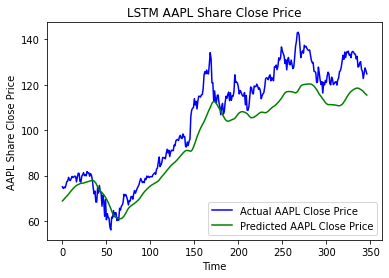

In [ ]:
plt.plot(real_prices, color='blue', label=f"Actual {ticker} Close Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {ticker} Close Price")
plt.title(f"LSTM {ticker} Share Close Price")
plt.xlabel('Time')
plt.ylabel(f'{ticker} Share Close Price')
plt.legend()
plt.show()

#Predict next day

In [ ]:
#Predict the following day's closing price.
start_date = dt.datetime.now()

real_data = [model_inputs[len(model_inputs) - lookback_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
#inverse transform the values from 0-1 to real values for interpretability.
prediction = scaler.inverse_transform(prediction)
print(f"Close Prediction for the next market day AFTER:{start_date} is: {prediction}")

Close Prediction for the next market day AFTER:2021-05-19 13:28:37.260236 is: [[115.16106]]
